# Loading Data

이전에 .npz파일로 저장한 데이터를 불러오겠습니다.

In [1]:
import numpy as np

filename = "./resampled_data.npz"
npzfile = np.load(filename)
print(npzfile.files)

['target_data', 'non_target_data']


In [2]:
target_data = npzfile['target_data']
non_target_data = npzfile['non_target_data']

print("Target data shape: ", target_data.shape)
print("Non-target data shape: ", non_target_data.shape)

Target data shape:  (75, 32, 32)
Non-target data shape:  (300, 32, 32)


# Classification

불러온 데이터와, Target은 1, Non-target은 0으로 정답을 만들어줍니다. 이후, 잘 불러와졌는지 첫 번째 데이터를 확인합니다.

In [3]:
from sklearn.model_selection import train_test_split

X = np.concatenate([target_data, non_target_data])
y = np.concatenate([np.ones(target_data.shape[0]), np.zeros(non_target_data.shape[0])])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=777)
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", y_train.shape)
print(X_train[0, 0, :])
print("\nX_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print(X_test[0, 0, :])

X_train shape:  (281, 32, 32)
Y_train shape:  (281,)
[  1.60218924   2.45750807  -5.73704155  -0.39830936  -0.58856095
  -1.88942423   3.62877279   3.7125499    1.65790269  -2.47709338
  -4.84796002  -2.91333102  -2.59842915  -4.39957614   5.29074272
   1.81107388   0.22134676  -6.20208792   6.17205169   6.56898446
  15.86684913   9.23249772   4.2213452   -3.6880042  -10.76734107
  -1.92747658  -5.90540743  -1.35890319 -10.51475778  -0.19431414
  -3.24503877  -3.11785104]

X_test shape:  (94, 32, 32)
y_test shape:  (94,)
[  3.36334193   1.11245855  -0.90455152  -3.71186998  -0.08337389
  -2.71506041  -4.62245867  -1.89613542   2.48586613  -6.97184154
   1.03915005   0.20767989  -0.426929     7.92042493   3.13434548
   1.58683091  -3.83570429  -0.67309755  -0.83427499   1.99654454
  10.9997141   -1.51422384   5.23661765  -7.2941492    1.38725739
   2.76369284  29.27995727  52.54985141  16.47463513 -23.66084727
 -47.31426763 -43.62883043]


### Decision Tree

Decision Tree를 사용하여 P300을 검출합니다. GridSearchCV를 통해 최적의 hyperparameter를 찾습니다.

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier()
parameters = {'criterion': ['entropy'],
              'min_samples_leaf': [10, 20, 30, 50, 100],
              'random_state': [777]}

X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
gridsearch = GridSearchCV(clf, parameters, scoring='accuracy', cv=3)
gridsearch.fit(X_train_reshaped, y_train)

print(f'gridsearch.best_params_ = {gridsearch.best_params_}')
best_clf = gridsearch.best_estimator_
print(best_clf)

gridsearch.best_params_ = {'criterion': 'entropy', 'min_samples_leaf': 50, 'random_state': 777}
DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50,
                       random_state=777)


In [5]:
from sklearn.metrics import accuracy_score

y_pred = best_clf.predict(X_test_reshaped)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy)

Accuracy:  0.8297872340425532


[Text(488.25, 237.82500000000002, 'X[814] <= 2.014\nentropy = 0.741\nsamples = 281\nvalue = [222, 59]'),
 Text(390.6, 169.875, 'X[243] <= -1.111\nentropy = 0.57\nsamples = 223\nvalue = [193, 30]'),
 Text(195.3, 101.92500000000001, 'X[608] <= -0.911\nentropy = 0.191\nsamples = 102\nvalue = [99, 3]'),
 Text(97.65, 33.974999999999994, 'entropy = 0.0\nsamples = 52\nvalue = [52, 0]'),
 Text(292.95000000000005, 33.974999999999994, 'entropy = 0.327\nsamples = 50\nvalue = [47, 3]'),
 Text(585.9000000000001, 101.92500000000001, 'X[356] <= 0.608\nentropy = 0.766\nsamples = 121\nvalue = [94, 27]'),
 Text(488.25, 33.974999999999994, 'entropy = 0.376\nsamples = 55\nvalue = [51, 4]'),
 Text(683.5500000000001, 33.974999999999994, 'entropy = 0.933\nsamples = 66\nvalue = [43, 23]'),
 Text(585.9000000000001, 169.875, 'entropy = 1.0\nsamples = 58\nvalue = [29, 29]')]

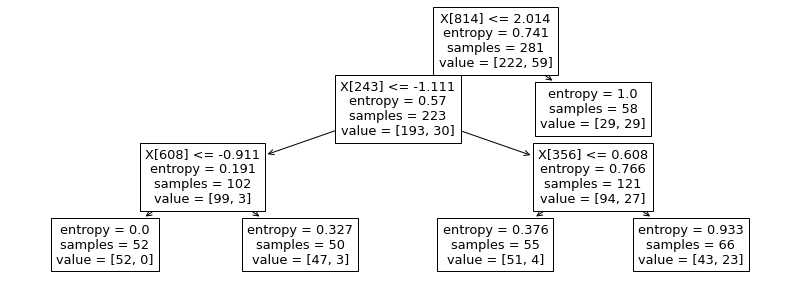

In [6]:
import sklearn
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
sklearn.tree.plot_tree(best_clf)

814번째 값이 2.014보다 작은지를 가장 큰 차이로 두고 있으니, 어떤 값인지 찾아봅시다.

한 데이터가 32 Channel x 32 Time 으로 이루어져 있으니, 814번째가 어디인지 간단한 수식을 통해 찾아볼 수 있습니다.

**(814 // 32) + 1 Channel, (814 % 32) Time** = 26번째 Channel, 14번째 Time

1300ms를 32개로 나눴으니, 14번째 Time은 대략 570ms 정도 되므로, -0.3s ~ 1s의 데이터에서 FC2 Channel의 270ms ~ 310ms정도를 중요하게 보고 있다고 볼 수 있습니다. 이는 우리가 생각한 P300, 즉 자극 발생 이후 300ms즈음에 나타나는 신호가 2.014보다 큰지 작은지를 중요하게 판단하고 있다고 볼 수 있습니다.


243번째 데이터는 C3 Channel의 460ms, 608번째 데이터는 P8 Channel의 -300ms, 356번째 데이터는 P3 Channel의 -140ms입니다.

### Random Forest

Random Forest를 이용하여 P300을 검출합니다. GridSearchCV를 통해 최적의 hyperparameter를 찾습니다.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()
parameters = {'criterion': ['entropy'],
              'n_estimators': [1, 5, 10, 30, 50, 100],
              'random_state': [777]}
gridsearch = GridSearchCV(clf, parameters, scoring='accuracy', cv=3)
gridsearch.fit(X_train_reshaped, y_train)

print(f'gridsearch.best_params_ = {gridsearch.best_params_}')
best_clf = gridsearch.best_estimator_
print(best_clf)

gridsearch.best_params_ = {'criterion': 'entropy', 'n_estimators': 10, 'random_state': 777}
RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=777)


In [8]:
from sklearn.metrics import accuracy_score

y_pred = best_clf.predict(X_test_reshaped)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy)

Accuracy:  0.8191489361702128


## Convolutional Neural Network

딥러닝 기법 중 하나인 CNN을 이용하여 P300을 검출합니다.

In [9]:
import warnings
import torch
import random
warnings.filterwarnings("ignore")

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(777)

우리는 아래와 같이 생긴 모델을 구현할 예정입니다.

![CNN_structure](./Images/CNN_structure.png)

In [10]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv2d(1, 6, 3, 1, padding=True)
        conv2 = nn.Conv2d(6, 16, 3, 1, padding=True)
        max_pool = nn.MaxPool2d(2)
        
        fc1 = nn.Linear(16 * 8 * 8, 32)
        out = nn.Linear(32, 2)
        
        # Batch x Channel x Height x Width
        self.conv = nn.Sequential(
            conv1,  # N x 1 x 32 x 32 -> N x 6 x 32 x 32
            nn.ReLU(),
            max_pool,  # N x 6 x 32 x 32 -> N x 6 x 16 x 16
            conv2,  # N x 6 x 16 x 16 -> N x 16 x 16 x 16
            nn.ReLU(),
            max_pool,  # N x 16 x 16 x 16 -> N x 16 x 8 x 8
        )
        
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            nn.ReLU(),
            out,  # N x 32 -> N x 2
            nn.Softmax()
        )

    def forward(self, x):
        x = self.conv(x)
        
        dim = 1
        for d in x.size()[1:]: # N x 16 x 8 x 8
            dim = dim * d
            
        x = x.view(-1, dim)
        x = self.fc(x)
        return x

딥러닝에 사용되는 데이터는 tensor의 형태이기 때문에, 적절한 변환이 필요합니다. 미리 준비된 EEGDataset Class를 활용하여 데이터를 가져옵니다.

In [11]:
from EEGDataset import EEGDataset
from torch.utils.data import DataLoader
import torch

batch_size = 4

train_loader = DataLoader(
                EEGDataset(X_train, y_train), 
                batch_size=batch_size, 
                shuffle=True)

test_loader = DataLoader(
                EEGDataset(X_test, y_test),
                batch_size=batch_size,
                shuffle=False)

이후, Hyperparameter를 설정하고, 학습을 시킵니다

In [12]:
import torch
import torch.nn as nn
from torch import optim

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN().to(DEVICE)

criterion = nn.BCELoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 10

In [13]:
from sklearn.metrics import accuracy_score

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

num_batches = len(train_loader)
for epoch in range(epochs):
    train_loss = 0
    train_acc = 0
    for i, data in enumerate(train_loader):
        """ 
        이번 학습에 사용될 데이터를 Batch 단위로 불러옵니다.
        우리는 이전에 batch_size를 4로 설정했으므로, 4개의 데이터가 불러와집니다.
        """
        data, label = data['data'].float().to(DEVICE), data['labels'].float().to(DEVICE)
        
        """
        optimizer.zero_grad(): 함수를 사용하여 기존에 남아있던 gradient를 모두 제거해줍니다.
        이는 이전 데이터가 새로 학습될 데이터에 영향을 끼치는 것을 막아줍니다.
        
        output = model(data): CNN 모델에 학습 데이터를 넣고 결과를 만들어냅니다.
        
        loss = criterion(output, label): 모델이 만들어낸 결과와, 실제 정답간의 차이를 이용해서 오차 값을 만들어 냅니다.
        추후에 이 값을 이용하여 모델이 학습을 하게 됩니다.
        
        loss.backward(): 위에서 만들어낸 오차 값을 각 노드에게 전파하여 각 노드가 업데이트 해야 할 오차가 얼마인지 찾아냅니다.
        
        optimizer.stop(): 각 노드별로 받은 오차를 가지고 optimizer의 방법 (여기서는 Adam)을 기반으로 weight를 업데이트 합니다.
        """
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        # Visualization을 위해 loss값과 accuracy를 저장합니다.
        train_loss += loss.item()
        train_acc += accuracy_score(np.argmax(label.detach().numpy(), axis=1), np.argmax(output.detach().numpy(), axis=1))
        
        """
        10번의 batch마다 test를 진행합니다.
        모델을 test할 때는 weight를 업데이트 시키면 안되기 때문에 torch.no_grad()를 이용합니다.
        """
        if (i + 1) % 10 == 0:
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                for j, test_data in enumerate(test_loader):
                    test_data, test_label = test_data['data'].float().to(DEVICE), test_data['labels'].float().to(DEVICE)
                    test_output = model(test_data)
                    loss = criterion(test_output, test_label)
                    test_loss += loss.item()
                    test_acc += accuracy_score(np.argmax(test_label.detach().numpy(), axis=1), np.argmax(test_output.detach().numpy(), axis=1))
            
            print('epoch: {}/{} | step: {}/{} | train_loss: {:.4f} | test_loss: {:.4f} | acc: {:.4f}'.format(
                epoch + 1, epochs, i + 1, num_batches, train_loss / 10, test_loss / len(test_loader), test_acc / len(test_loader)
            ))
            
            train_loss_list.append(train_loss / 10)
            train_acc_list.append(train_acc / 10)
            test_loss_list.append(test_loss / len(test_loader))
            test_acc_list.append(test_acc / len(test_loader))
            train_loss = 0
            train_acc = 0

epoch: 1/10 | step: 10/71 | train_loss: 0.7823 | test_loss: 0.5154 | acc: 0.8333
epoch: 1/10 | step: 20/71 | train_loss: 0.6757 | test_loss: 0.4867 | acc: 0.8229
epoch: 1/10 | step: 30/71 | train_loss: 0.5496 | test_loss: 0.4930 | acc: 0.8333
epoch: 1/10 | step: 40/71 | train_loss: 0.5729 | test_loss: 0.4486 | acc: 0.8333
epoch: 1/10 | step: 50/71 | train_loss: 0.5773 | test_loss: 0.4703 | acc: 0.8333
epoch: 1/10 | step: 60/71 | train_loss: 0.3600 | test_loss: 0.4632 | acc: 0.8333
epoch: 1/10 | step: 70/71 | train_loss: 0.6118 | test_loss: 0.4444 | acc: 0.8333
epoch: 2/10 | step: 10/71 | train_loss: 0.4259 | test_loss: 0.4429 | acc: 0.8333
epoch: 2/10 | step: 20/71 | train_loss: 0.4196 | test_loss: 0.4478 | acc: 0.8333
epoch: 2/10 | step: 30/71 | train_loss: 0.4207 | test_loss: 0.4723 | acc: 0.8333
epoch: 2/10 | step: 40/71 | train_loss: 0.4312 | test_loss: 0.4711 | acc: 0.8542
epoch: 2/10 | step: 50/71 | train_loss: 0.5361 | test_loss: 0.4802 | acc: 0.8125
epoch: 2/10 | step: 60/71 | 

Loss와 Accuracy에 대한 그래프를 그려보면, 다음과 같이 나옵니다

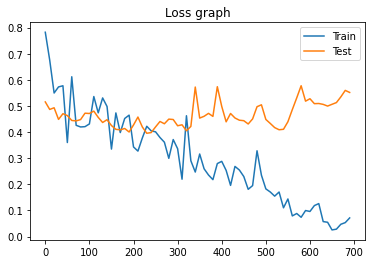

In [14]:
x_tick = np.arange(0, len(train_loss_list) * 10, 10)
plt.title('Loss graph')
plt.plot(x_tick, train_loss_list, label='Train')
plt.plot(x_tick, test_loss_list, label='Test')
plt.legend()

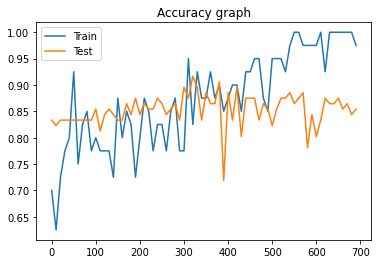

In [15]:
x_tick = np.arange(0, len(train_acc_list) * 10, 10)
plt.title('Accuracy graph')
plt.plot(x_tick, train_acc_list, label='Train')
plt.plot(x_tick, test_acc_list, label='Test')
plt.legend()

대략 2~300번째 small-batch부터 over-fitting이 발생하는 것을 볼 수 있습니다.

**Decision Tree**는 82.98%의 정확도를 냈고, **Random Forest**는 81.91%의 정확도를, **CNN**은 평균적으로 85%정도의 정확도를 낸 것을 볼 수 있었습니다.